In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import wfdb
from scipy import signal
import pandas as pd

import sys
sys.path.append("..")
sys.path.append("C:\\Users\\Jonas\\OneDrive\\Uni\\SoSe23\\RDS\\git-repo\\vg-ecg-detectors\\src")

from src.vg_beat_detectors.vg_metric import VisGraphMetric
from src.vg_beat_detectors.fast_nvg import FastNVG

path = "C:\\Users\\Jonas\\OneDrive\\Uni\\SoSe23\\RDS\\git-repo\\vg-ecg-detectors\\correlation.csv"

In [2]:
def pysionet_db(data='105', db='mitdb', filtered=False, left=0, right=None, normalize=False):
    sig = wfdb.rdsamp(data, sampfrom=left, sampto=right, pn_dir=db)[0][:, 0]

    annotations = wfdb.rdann(data, 'atr', sampfrom=left, sampto=right, pn_dir=db, summarize_labels=True)
    a_sym = np.array(annotations.symbol)
    annotation_pos = annotations.sample[np.in1d(a_sym, ['·','N','L','R', 'A', 'a', 'J', 'S', 'V','F', 'e', 'j', 'E', '/', 'f','Q', '!'])] - left

    artifacts = annotations.sample[np.in1d(a_sym, ['|'])] - left
    fs = annotations.fs

    t = np.arange(left, len(sig)+left,1)/fs


    if filtered:
        nyq = 0.5 * fs
        lowcut = 4      # cutoff frequency 4Hz
        order = 2
        high = lowcut / nyq
        b, a = signal.butter(order, high, btype='highpass')
        sig = signal.filtfilt(b, a, sig)

        nyq = fs / 2
        lowCut = 5 / nyq  #cut off frequencies are normalized from 0 to 1, where 1 is the Nyquist frequency
        highCut = 15 / nyq
        order = 2
        b,a = signal.butter(order, [lowCut, highCut], btype = 'bandpass')
        sig = signal.filtfilt(b, a, sig)

    if normalize:
        sig = sig - sig.min()
        sig = sig / sig.max()

    return t, sig, fs, annotation_pos


In [3]:
def compute_ACDC(rr, fs, PRSA=False):
   rr = rr/fs*1000
   segment_length = 4
   l = segment_length//2
   r = segment_length - l
   N = len(rr)

   # do the full computation if needed
   sum_acceleration = np.zeros(segment_length)
   num_acceleration = 0
   sum_decceleration = np.zeros(segment_length)
   num_decceleration = 0

   for i in range(l,N-r):
      # acceleration
      if rr[i] < rr[i-1] and rr[i] > 0.95 * rr[i-1]:
         sum_acceleration += rr[i-l:i+r]
         num_acceleration += 1
         # deceleration
      elif rr[i] > rr[i-1] and rr[i] < 1.05 * rr[i-1]:
         sum_decceleration += rr[i-l:i+r]
         num_decceleration += 1
        
   PRSA_AC = sum_acceleration/num_acceleration
   PRSA_DC = sum_decceleration/num_decceleration

   AC = (PRSA_AC[l]+PRSA_AC[l+1]-PRSA_AC[l-1]-PRSA_AC[l-2])/4
   DC = (PRSA_DC[l]+PRSA_DC[l+1]-PRSA_DC[l-1]-PRSA_DC[l-2])/4

   return AC, DC, PRSA_AC, PRSA_DC

def segmentwise_ACDC(rr, fs):
   rr = rr/fs*1000
   N = len(rr)

   values = []
   labels = []
   indices = []

   for i in range(2,N-1):
      # compute AC/DC formula if not outlier, i.e., in 5% bounds
      if not 1.05 * rr[i-1] > rr[i] > 0.95 * rr[i-1]:
         values.append(np.nan)
         labels.append("outlier")
         indices.append(i)
         continue

      values.append((rr[i]+rr[i+1]-rr[i-1]-rr[i-2])/4)
      indices.append(i)

      # label as AC or DC
      if rr[i] <= rr[i-1]:
         labels.append("AC")
      elif rr[i] > rr[i-1]:
         labels.append("DC")

   return np.array(values), np.array(labels), np.array(indices)

In [28]:
experiments = [100, 	104, 	108, 	113, 	117, 	122, 	201, 	207, 	212, 	217, 	222, 	231,
            101, 	105, 	109, 	114, 	118, 	123, 	202, 	208, 	213, 	219, 	223, 	232,
            102, 	106, 	111, 	115, 	119, 	124, 	203, 	209, 	214, 	220, 	228, 	233,
            103, 	107, 	112, 	116, 	121, 	200, 	205, 	210, 	215, 	221, 	230, 	234]

def calc_correlations(VGM, beats_per_window, metrics):
    for ex in experiments:
        data = []
        t, x, fs, true_peaks = pysionet_db(data=str(ex), db='mitdb', filtered=False,normalize=False)#, right=int(5*60*360)
        if true_peaks.size == 0:
            continue
        rr = np.diff(true_peaks)

        # calculate AC/DC
        values, labels, indices = segmentwise_ACDC(rr, fs)
        values = values[labels != "outlier"]
        indices = indices[labels != "outlier"]
        labels = labels[labels != "outlier"]

        #print(metrics)
        m = VGM.calc_metric(rr, metrics=metrics)
        for name, (m, ix_m) in m.items():
            ix_m += beats_per_window//2 # shift to middle of window
            # get common indices
            idx = np.intersect1d(indices, ix_m)

            values = values[np.in1d(indices, idx)]
            m = m[np.in1d(ix_m, idx)]
            labels = labels[np.in1d(indices, idx)]
            
            AC_true = values[labels == "AC"]
            AC_pred = m[labels == "AC"]
            DC_true = values[labels == "DC"]
            DC_pred = m[labels == "DC"]

            AC = np.corrcoef(AC_true, AC_pred, rowvar=False)[0,1]
            DC = np.corrcoef(DC_true, DC_pred, rowvar=False)[0,1]
            ALL = np.corrcoef(values, m, rowvar=False)[0,1]

            if True or np.any(np.array([ALL, AC, DC]) > 0.5):
                print(f"\n {ex}: {name}_{str(VGM.directed)}_{str(VGM.edge_weight)}_{VGM.beats_per_window} \t AC: {AC} \t DC: {DC} \t ALL: {ALL}")

            data.append([ex, name, ALL, AC, DC, beats_per_window, edge_weight, direction, freq_domain])  

        df = pd.DataFrame(data, columns=['ex', 'name', 'ALL', 'AC', 'DC', 'beats_per_window', 'edge_weight', 'direction', 'freq_domain'])
        df.to_csv(path, index=False, mode='a', header=False)   
        break

beats_per_window = 4
freq_domain = False
directions = [None, 'left_to_right']
edge_weights = [None, 'slope', 'abs_slope', 'angle', 'abs_angle', 'distance', 'sq_distance', 'v_distance', 'abs_v_distance', 'h_distance', 'abs_h_distance']

#metrics=['minimum_cut_value_left_to_right', 'maximum_flow_value_left_to_right', 'shortest_path_length_left_to_right']
# VGM = VisGraphMetric(edge_weight="slope", direction=None, freq_domain=freq_domain, beats_per_window=beats_per_window, beats_per_step=1)
for edge_weight in edge_weights:
    for direction in directions:
        print(edge_weight, direction)
        VGM = VisGraphMetric(edge_weight=edge_weight, direction=direction, freq_domain=freq_domain, beats_per_window=beats_per_window, beats_per_step=1)
        metrics = VGM.get_available_metrics()
        calc_correlations(VGM, beats_per_window, metrics)

slope None
The metric local_reaching_centrality is not defined for undirected graphs. Set the parameter "direction" of the main class to one of ['top_to_bottom', 'left_to_right'].

 100: local_edge_connectivity_None_slope_4 	 AC: -0.05369949388760527 	 DC: 0.07767935753252901 	 ALL: 0.0011137483848680464

 100: local_node_connectivity_None_slope_4 	 AC: -0.05369949388760527 	 DC: 0.07767935753252901 	 ALL: 0.0011137483848680464

 100: closeness_centrality_None_slope_4 	 AC: -0.19730245225194962 	 DC: -0.19928475125542344 	 ALL: 0.07602317806955713

 100: dispersion_None_slope_4 	 AC: nan 	 DC: nan 	 ALL: nan


c:\Users\Jonas\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\Jonas\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [48]:
df = pd.read_csv(path)
df = df.dropna(axis=0, how='any')
df

,ex,metric,ALL,AC,DC,beats_per_window,edge_weight,edge_direction,fft
75,100,node_connectivity,-0.241923,0.101999,0.171912,4,slope,left_to_right,False
76,100,average_node_connectivity,0.014754,-0.009602,0.049733,4,slope,left_to_right,False
77,100,average_clustering,0.034731,0.058886,-0.021491,4,slope,left_to_right,False
85,100,dag_longest_path_length,0.722095,0.562404,0.713632,4,slope,left_to_right,False
86,100,average_shortest_path_length,-0.030473,-0.043000,0.004189,4,slope,left_to_right,False
...,...,...,...,...,...,...,...,...,...
1609,108,density,0.032214,-0.062323,0.133095,4,abs_h_distance,left_to_right,False
1610,108,local_edge_connectivity,0.035653,-0.099922,0.196682,4,abs_h_distance,left_to_right,False
1612,108,closeness_centrality,-0.140962,-0.349293,-0.249375,4,abs_h_distance,left_to_right,False
1615,108,maximum_flow_value_left_to_right,0.039811,-0.071101,0.176890,4,abs_h_distance,left_to_right,False


In [49]:
df['max'] = df[['ALL', 'AC', 'DC']].abs().max(axis=1)
df.sort_values(by=["ALL", "AC", "DC", "metric"], ascending=False).head(10)

,ex,metric,ALL,AC,DC,beats_per_window,edge_weight,edge_direction,fft,max
1467,108,shortest_path_length_left_to_right,0.970527,0.988696,0.992867,4,v_distance,left_to_right,False,0.992867
389,100,shortest_path_length_left_to_right,0.962325,0.979525,0.980755,4,v_distance,left_to_right,False,0.980755
928,104,shortest_path_length_left_to_right,0.938627,0.976584,0.981501,4,v_distance,left_to_right,False,0.981501
95,100,shortest_path_length_left_to_right,0.921807,0.965358,0.923429,4,slope,left_to_right,False,0.965358
1173,108,shortest_path_length_left_to_right,0.909541,0.944142,0.930519,4,slope,left_to_right,False,0.944142
634,104,shortest_path_length_left_to_right,0.873276,0.941874,0.924749,4,slope,left_to_right,False,0.941874
732,104,shortest_path_length_left_to_right,0.791218,0.742032,0.771009,4,angle,left_to_right,False,0.791218
193,100,shortest_path_length_left_to_right,0.788069,0.719260,0.664248,4,angle,left_to_right,False,0.788069
183,100,dag_longest_path_length,0.778580,0.607170,0.688730,4,angle,left_to_right,False,0.778580
722,104,dag_longest_path_length,0.759934,0.636995,0.751441,4,angle,left_to_right,False,0.759934


In [103]:
df0 = df.set_index(['metric', 'beats_per_window', 'edge_weight', 'edge_direction', 'fft', 'ex'])
df0 = df0.stack()
df0 = df0.reset_index()
df0 = df0.rename(columns={'level_6': 'type', 0: 'value'}) 
df0 = df0.set_index(['metric', 'beats_per_window', 'edge_weight', 'edge_direction', 'fft'])
df0.index = df0.index.map(str)
#df0.index = df0.index.map('_'.join)
#df0 = df0.dropna(axis=0, how='any')
df0 = df0[df0['type'].isin(['AC', 'DC'])]
df0 = df0.sort_values(by=['value'], ascending=False)
df0

,ex,type,value
"('shortest_path_length_left_to_right', 4, 'v_distance', 'left_to_right', False)",108,DC,0.992867
"('shortest_path_length_left_to_right', 4, 'v_distance', 'left_to_right', False)",108,AC,0.988696
"('shortest_path_length_left_to_right', 4, 'v_distance', 'left_to_right', False)",104,DC,0.981501
"('shortest_path_length_left_to_right', 4, 'v_distance', 'left_to_right', False)",100,DC,0.980755
"('shortest_path_length_left_to_right', 4, 'v_distance', 'left_to_right', False)",100,AC,0.979525
...,...,...,...
"('dag_longest_path_length', 4, 'abs_slope', 'left_to_right', False)",100,AC,-0.606586
"('shortest_path_length_left_to_right', 4, 'sq_distance', 'left_to_right', False)",100,AC,-0.613370
"('dag_longest_path_length', 4, 'sq_distance', 'left_to_right', False)",100,AC,-0.651737
"('shortest_path_length_left_to_right', 4, 'distance', 'left_to_right', False)",100,AC,-0.668327


[(-0.5, 10.5)]

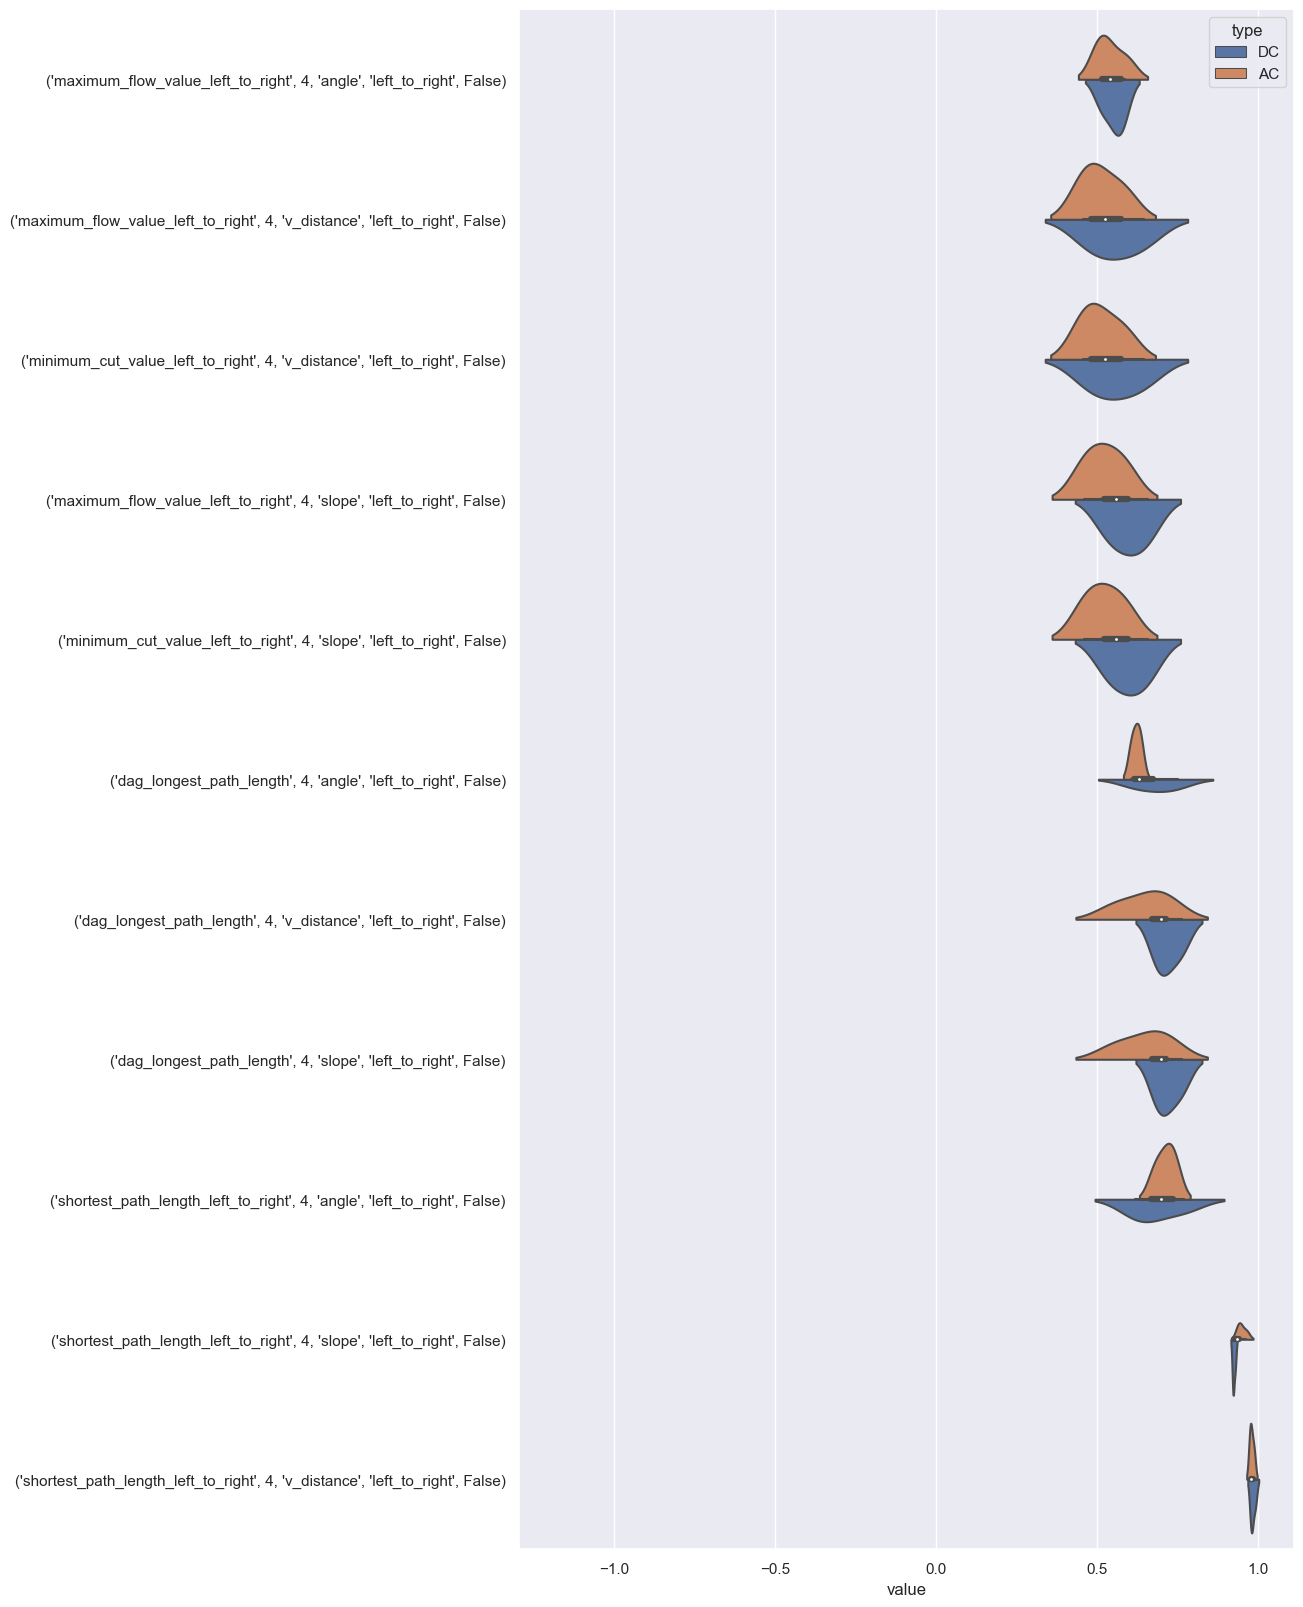

In [109]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,20)})
g = sns.violinplot(data=df0, y=df0.index, x="value", hue="type", split=True)
g.set(ylim=(-.5, 10.5))

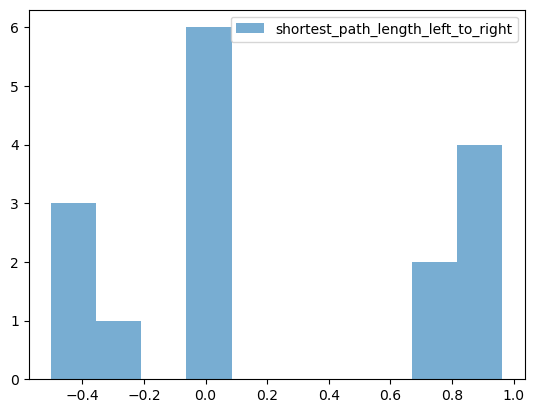

In [43]:

plt.hist(df[df["metric"]=="shortest_path_length_left_to_right"]["ALL"], alpha=0.6, label="shortest_path_length_left_to_right")
#plt.hist(df[df["metric"]=="shortest_path_length_left_to_right"]["ALL"], alpha=0.6, label="shortest_path_length_left_to_right")
plt.legend()

In [7]:
import plotly.express as px
fig = px.histogram(df, x="correlation", color="metric")
fig.show()

In [8]:
df.groupby(['metric', 'beats_per_window', 'edge_weight', 'edge_direction', 'fft'])['correlation'].agg(['mean', 'median'])

,,,,,mean,median
metric,beats_per_window,edge_weight,edge_direction,fft,,


In [ ]:
experiments = [100, 	104, 	108, 	113, 	117, 	122, 	201, 	207, 	212, 	217, 	222, 	231,
            101, 	105, 	109, 	114, 	118, 	123, 	202, 	208, 	213, 	219, 	223, 	232,
            102, 	106, 	111, 	115, 	119, 	124, 	203, 	209, 	214, 	220, 	228, 	233,
            103, 	107, 	112, 	116, 	121, 	200, 	205, 	210, 	215, 	221, 	230, 	234]

def calc_correlations(VGM, beats_per_window, metrics):
    data = []
    for ex in experiments:
        t, x, fs, true_peaks = pysionet_db(data=str(ex), db='mitdb', filtered=False,normalize=False)#, right=int(5*60*360)
        if true_peaks.size == 0:
            continue
        rr = np.diff(true_peaks)

        # calculate AC/DC
        values, labels, indices = segmentwise_ACDC(rr, fs)
        values = values[labels != "outlier"]
        indices = indices[labels != "outlier"]
        labels = labels[labels != "outlier"]

        print(ex)
        #print(metrics)
        m = VGM.calc_metric(rr, metrics=metrics)
        for name, (m, ix_m) in m.items():
            ix_m += beats_per_window//2 # shift to middle of window
            # get common indices
            idx = np.intersect1d(indices, ix_m)
            # calculate correlation
            values = values[np.in1d(indices, idx)]
            m = m[np.in1d(ix_m, idx)]
            labels = labels[np.in1d(indices, idx)]
            
            AC_true = values[labels == "AC"]
            AC_pred = m[labels == "AC"]
            DC_true = values[labels == "DC"]
            DC_pred = m[labels == "DC"]
            print(f"{name}: AC: {np.corrcoeff(AC_true, AC_pred, rowvar=False)}")
            print(f"{name}: DC: {np.corrcoeff(AC_true, AC_pred, rowvar=False)}")


            print(f"{name}_{str(VGM.directed)}_{str(VGM.edge_weight)}_{VGM.beats_per_window}: {corr[0,1]}")
            #data.append([ex, name, corr[0,1], beats_per_window, edge_weight, direction, freq_domain])  

        #df = pd.DataFrame(data, columns=['ex', 'name', 'corr', 'beats_per_window', 'edge_weight', 'direction', 'freq_domain'])
        #df.to_csv(path, index=False, mode='a', header=False)   
        break

beats_per_window = 4
freq_domain=False
directions=[None, 'left_to_right']
edge_weights = [None, 'slope', 'abs_slope', 'angle', 'abs_angle', 'distance', 'sq_distance', 'v_distance', 'abs_v_distance', 'h_distance', 'abs_h_distance']

#metrics = VGM.get_available_metrics()
metrics=['minimum_cut_value_left_to_right', 'maximum_flow_value_left_to_right', 'shortest_path_length_left_to_right']
# VGM = VisGraphMetric(edge_weight="slope", direction=None, freq_domain=freq_domain, beats_per_window=beats_per_window, beats_per_step=1)
for edge_weight in edge_weights:
    for direction in directions:
        print(edge_weight, direction)
        VGM = VisGraphMetric(edge_weight=edge_weight, direction=direction, freq_domain=freq_domain, beats_per_window=beats_per_window, beats_per_step=1)
        calc_correlations(VGM, beats_per_window, metrics)

In [9]:
path = "C:\\Users\\Jonas\\OneDrive\\Uni\\SoSe23\\RDS\\git-repo\\vg-ecg-detectors\\capacity_full.csv"
df = pd.read_csv(path)
df.corr()

,ex,AC,DC,median_shortest_path_length_left_to_right
ex,1.000000,0.060548,-0.077383,-0.280560
AC,0.060548,1.000000,0.785103,0.212425
DC,-0.077383,0.785103,1.000000,0.352800
median_shortest_path_length_left_to_right,-0.280560,0.212425,0.352800,1.000000
